**Problem statement:** 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

### Importing Skin Cancer Data


In [ ]:
## mounting google drive:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Resizing images to 180 x 180 and creating train dataset with 123 as the seed value
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Resizing images to 180 x 180 and creating validation dataset with 123 as the seed value
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List of all the classes of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Creating a visualize of one instance of all the nine classes present in the dataset

In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

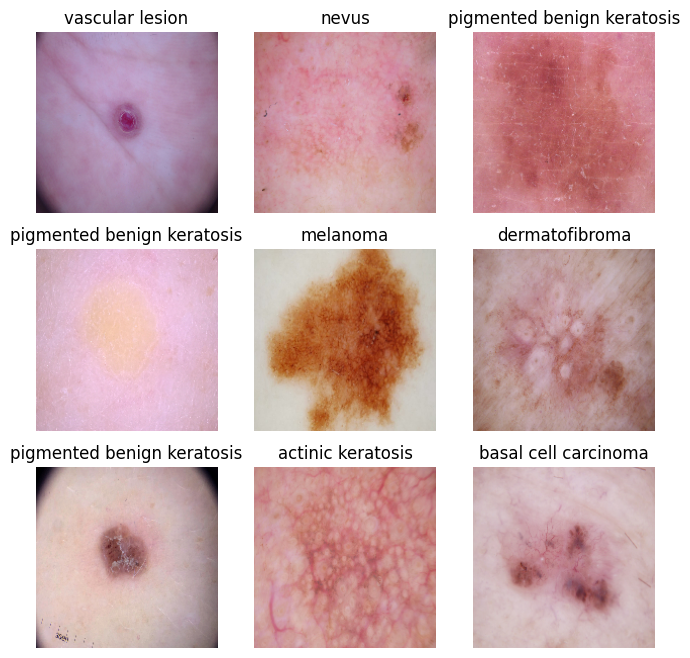

In [ ]:
#visualizing one image per given class of skin cancer
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.imshow(images[i].numpy().astype("uint8"))


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. 

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model1 = Sequential()

model1.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model1.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model1.add(layers.Dropout(0.25))

#Second Convulation Layer
model1.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model1.add(layers.Dropout(0.25))

#Third Convulation Layer
model1.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model1.add(layers.Dropout(0.25))



#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model1.add(layers.Flatten())

#Dense Layer
model1.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model1.add(layers.Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model1.add(layers.Dense(len(class_names),activation='softmax'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

### Compiling the model


In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [ ]:
epochs = 20
history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 61ms/step - loss: 2.3418 - accuracy: 0.1842 - val_loss: 2.0805 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0035 - accuracy: 0.2271 - val_loss: 1.9140 - val_accuracy: 0.2416
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 1.8684 - accuracy: 0.3092 - val_loss: 1.8289 - val_accuracy: 0.3758
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.7679 - accuracy: 0.3627 - val_loss: 1.6852 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 3s 58ms/step - loss: 1.6674 - accuracy: 0.4051 - val_loss: 1.6586 - val_accuracy: 0.4295
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6921 - accuracy: 0.4035 - val_loss: 1.5737 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6184 - accuracy: 0.4286 - val_loss: 1.6652 - val_accuracy: 0.3826
Epoch 8/20
56

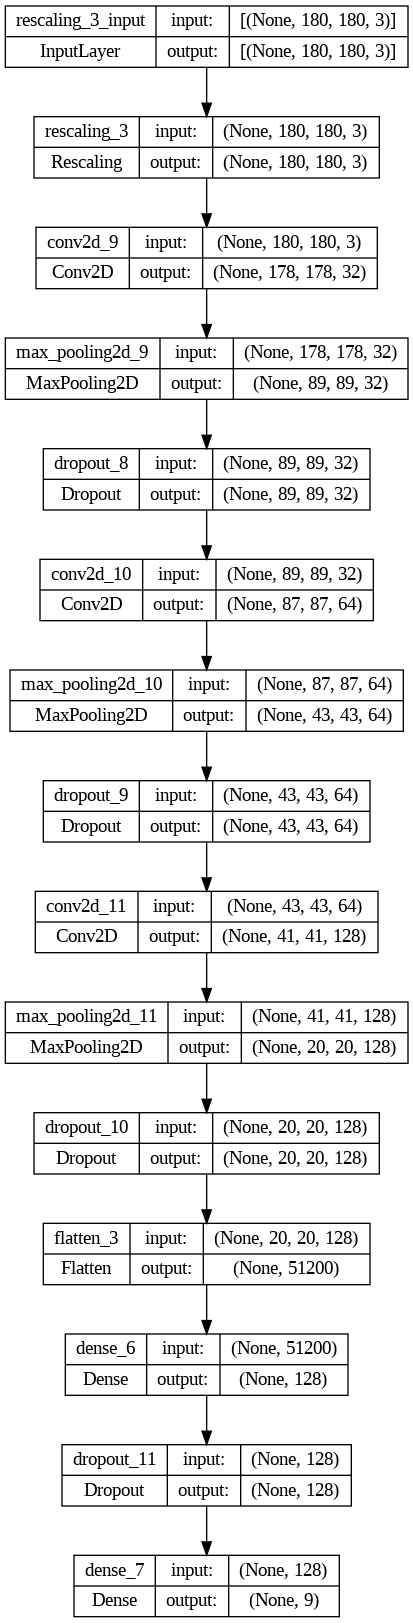

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True)


### Visualizing training results

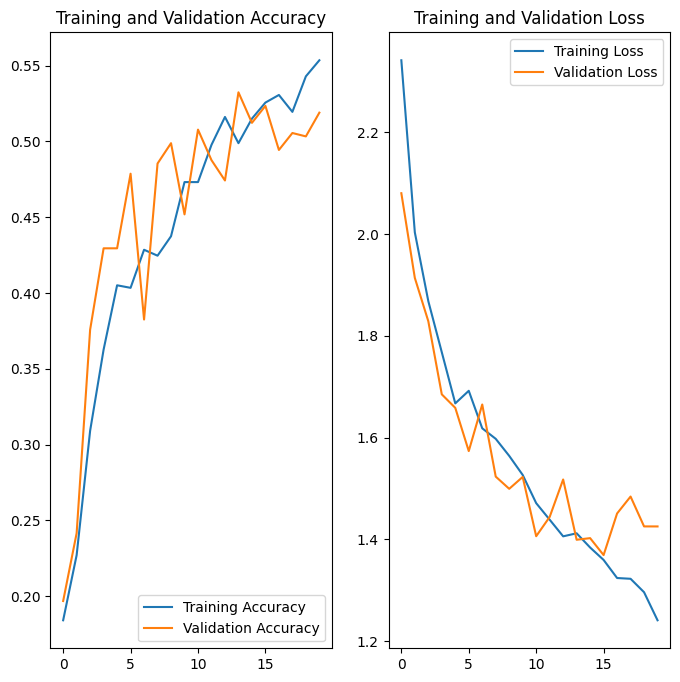

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:

As seen abover the Accuracy after 20 epochs is **53%** and validation accuracy is **53%**. This is a clear indication that our model is underfitting and isn't performing as well.


In [ ]:
# Choosing an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


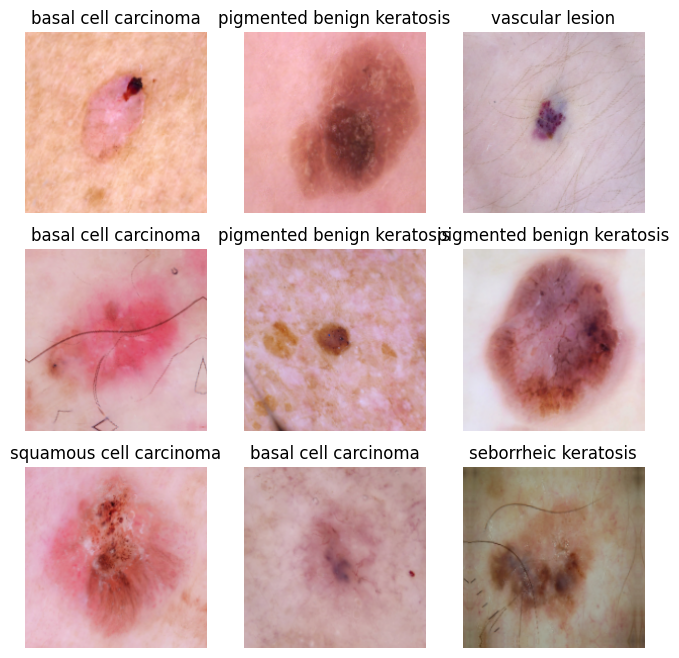

In [ ]:


plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Creating a new model with the augmented dataset:

### Model Number 2

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model2 = Sequential()

model2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))



#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

### Compiling the model

In [ ]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




### Training the model

In [ ]:
epochs = 20

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 5s 66ms/step - loss: 2.2221 - accuracy: 0.2070 - val_loss: 2.0547 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 1.9453 - accuracy: 0.2595 - val_loss: 1.8327 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 1.8345 - accuracy: 0.3270 - val_loss: 1.7327 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7495 - accuracy: 0.3728 - val_loss: 1.8729 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 1.7446 - accuracy: 0.3728 - val_loss: 1.8909 - val_accuracy: 0.3378
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6723 - accuracy: 0.3873 - val_loss: 1.6598 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6114 - accuracy: 0.4470 - val_loss: 1.6017 - val_accuracy: 0.4385
Epoch 8/20
56/56 [======

### Visualizing the results

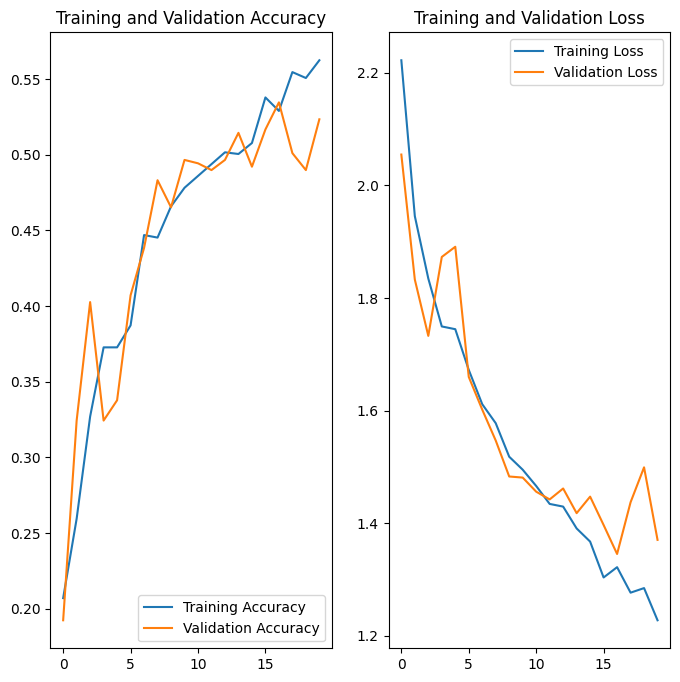

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 Findings

Training Accuracy: 56%

Validation Accuracy: 52%

The model is shows improvement in performance however we still see that the numbers on the models validation accuracy and accuracy are low which indicates that we need to improve our models performance.

#### **Context:** 
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

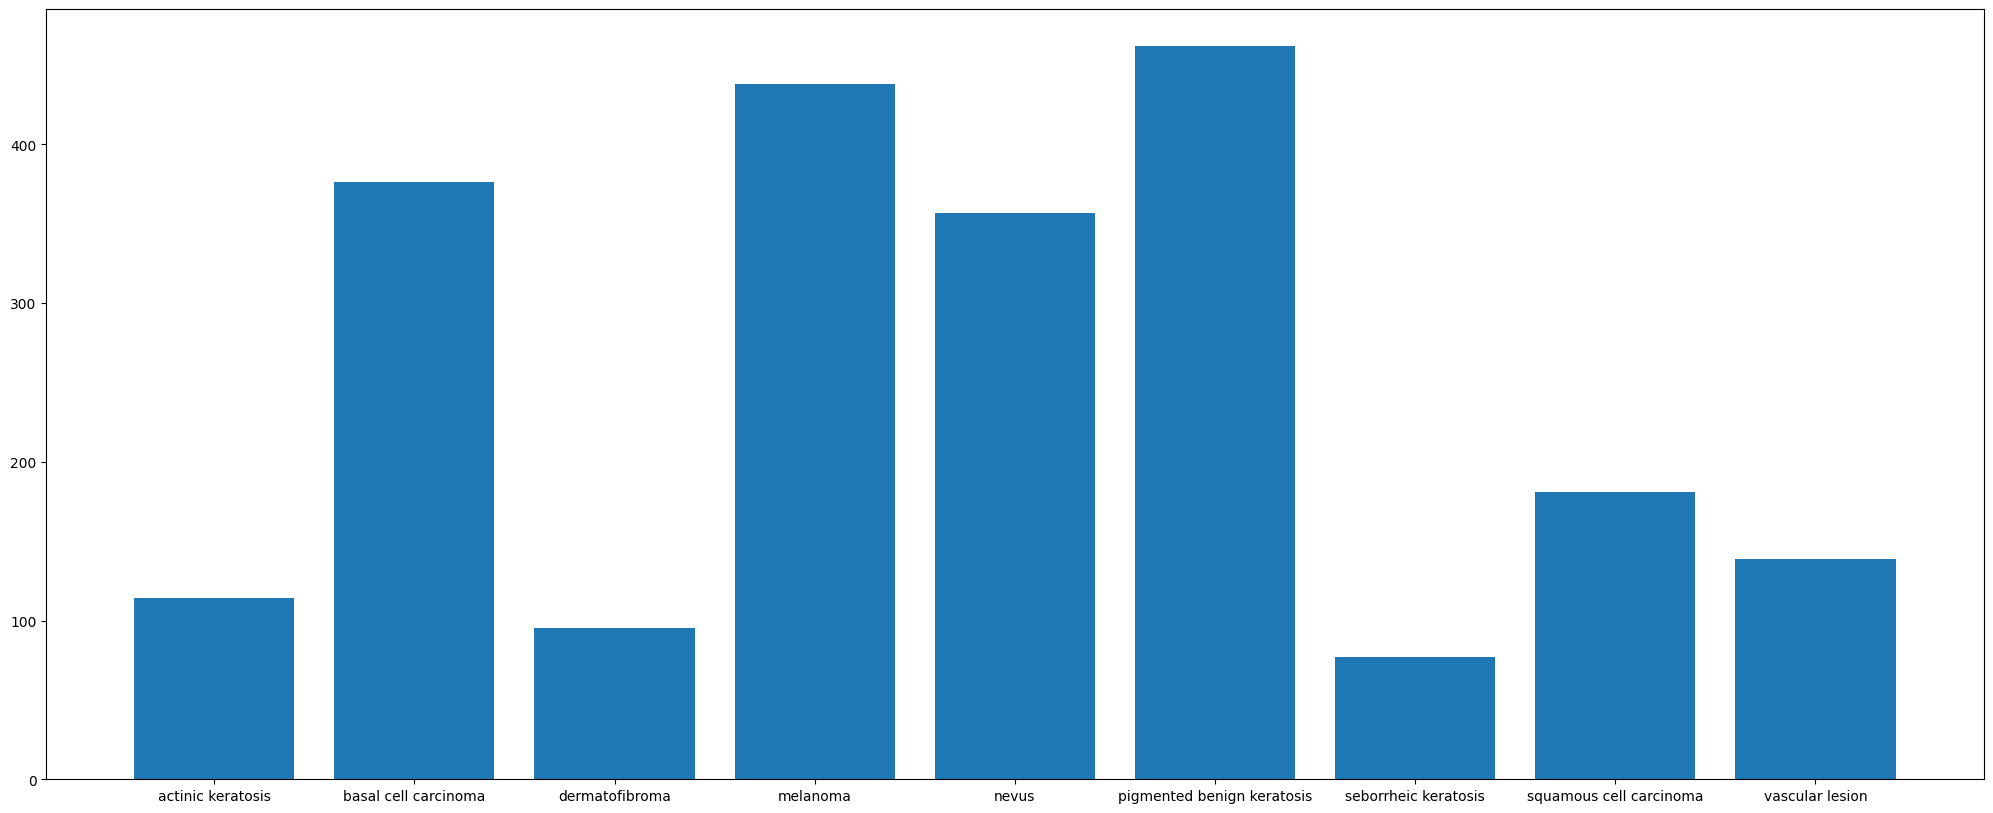

In [ ]:
#plotting the number of images in each Class
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Findings: 

As suspected there is a huge discrepancy in the number of samples across different classes. 

Pigmented benign kertosis seems to the largest number of samples follwed by melonoma and basel cell carcinoma respectively. Seborrheic keratosis has the least number of samples among also the classes with dermatofibroma and actinic keratosis the second and third least respectively.


#### Rectifying class imbalance
#### **Context:** Python's 'Augmentor' package (https://augmentor.readthedocs.io/en/master/) will help add more samples across all classes to irradicate class imbalance

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A4EDC7DF0>: 100%|██████████| 500/500 [00:24<00:00, 20.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9A4EC26D40>: 100%|██████████| 500/500 [00:27<00:00, 18.13 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9A4EC0BFD0>: 100%|██████████| 500/500 [00:22<00:00, 22.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9AD0263F40>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F9A5C10E590>: 100%|██████████| 500/500 [01:40<00:00,  4.97 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9AD06DC4C0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9A4EE9FFA0>: 100%|██████████| 500/500 [00:47<00:00, 10.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9A4EDA5B10>: 100%|██████████| 500/500 [00:20<00:00, 24.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9AD01D7D30>: 100%|██████████| 500/500 [00:22<00:00, 22.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### checking the distribution of augmented data after adding new images to the original training data.

<BarContainer object of 9 artists>

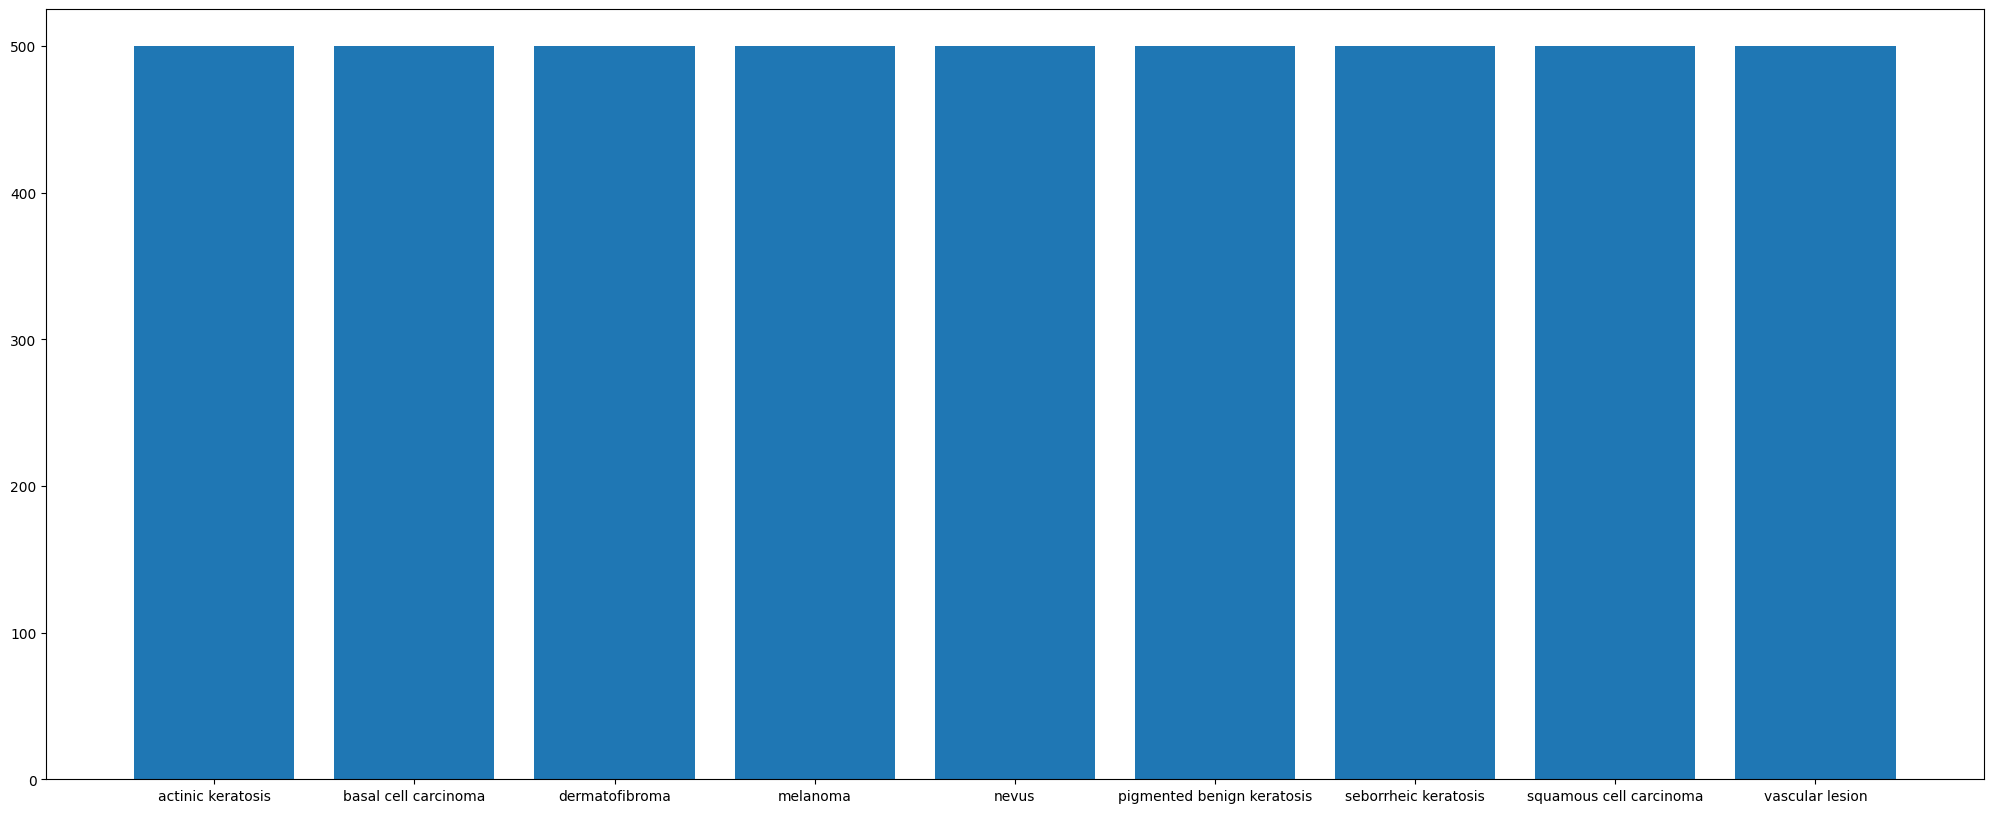

In [ ]:
# Checking the distribution of data. 
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'*/output/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [ ]:
from glob import glob

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
# Get Existing images in Dataframe
path_list=[]
lesion_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    lesion_list.append(name)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-50-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

We have added 500 images to all the classes to maintain some class balance. We can add more images if needed to improve training process.

#### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating the training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating the validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Creating the model

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model3 = Sequential()

model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))



#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                

#### Compiling the model

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

epochs = 30

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[earlystop]
)


Epoch 1/30
169/169 [==============================] - 12s 62ms/step - loss: 2.1877 - accuracy: 0.1688 - val_loss: 1.9193 - val_accuracy: 0.2717
Epoch 2/30
169/169 [==============================] - 10s 58ms/step - loss: 1.8375 - accuracy: 0.2858 - val_loss: 1.8152 - val_accuracy: 0.3118
Epoch 3/30
169/169 [==============================] - 10s 57ms/step - loss: 1.6995 - accuracy: 0.3535 - val_loss: 1.5651 - val_accuracy: 0.4187
Epoch 4/30
169/169 [==============================] - 9s 56ms/step - loss: 1.5685 - accuracy: 0.3943 - val_loss: 1.4324 - val_accuracy: 0.4736
Epoch 5/30
169/169 [==============================] - 10s 58ms/step - loss: 1.5079 - accuracy: 0.4282 - val_loss: 1.4630 - val_accuracy: 0.4796
Epoch 6/30
169/169 [==============================] - 10s 57ms/step - loss: 1.4434 - accuracy: 0.4529 - val_loss: 1.2977 - val_accuracy: 0.5056
Epoch 7/30
169/169 [==============================] - 9s 55ms/step - loss: 1.3820 - accuracy: 0.4675 - val_loss: 1.2890 - val_accuracy: 0

#### Visualizing the model results

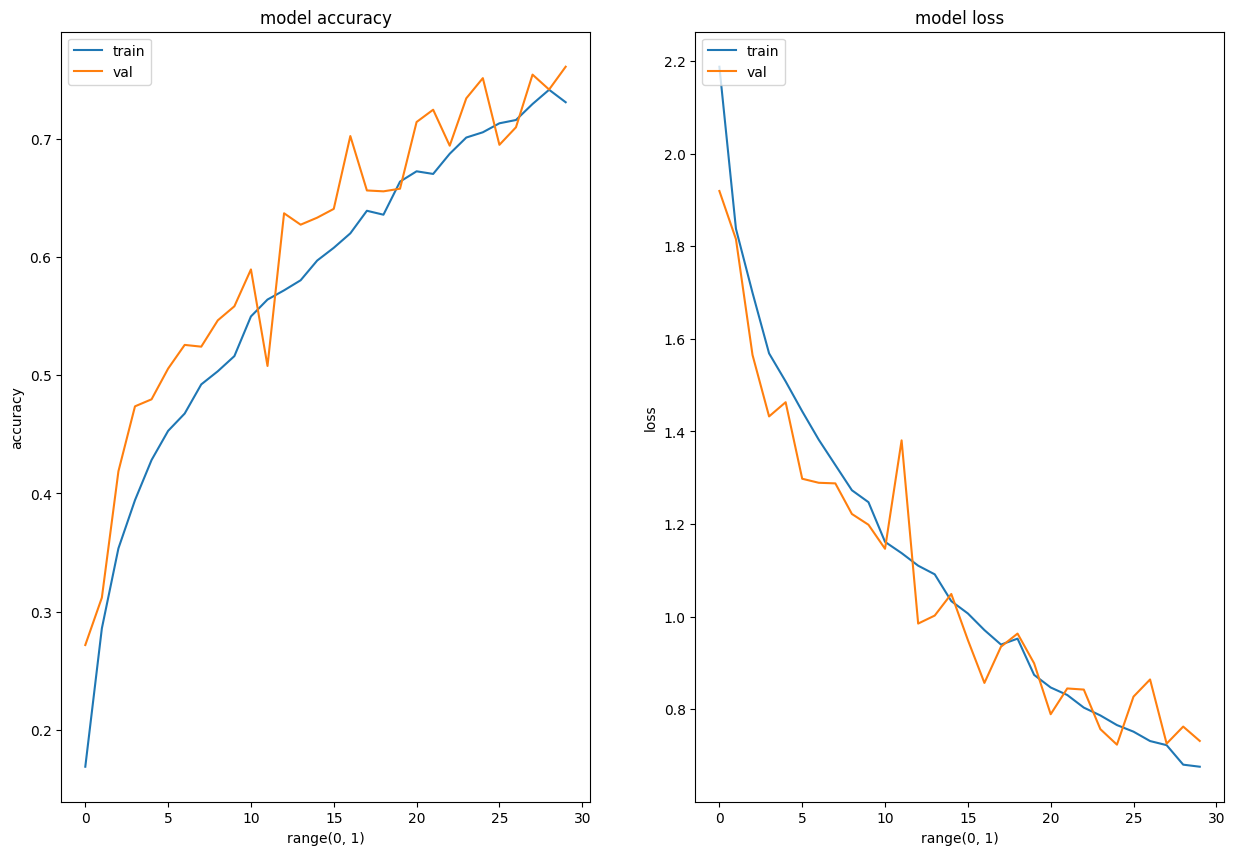

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Findings: 

Training Accuracy: 73.09%

Validation Accuracy: 76.10%

Augmetor has definitely helped our model performance and has improved both accuracy and validation accuracy. This model can be used as final model however, by decreasing or removing some of the dropout layers we may get and even better performance out of our model. 

### Creating the Model

In [ ]:
# Removing the first and lastt dropout layer o check model performanc
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model4 = Sequential()

model4.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model4.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))


#Second Convulation Layer
model4.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model4.add(layers.Dropout(0.25))

#Third Convulation Layer
model4.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model4.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model4.add(layers.Dropout(0.25))



#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model4.add(layers.Flatten())

#Dense Layer
model4.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model4.add(layers.Dropout(0.3))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model4.add(layers.Dense(len(class_names),activation='softmax'))

model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 43, 43, 64)      

### Compiling the model

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

epochs = 30

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=7,mode="auto",verbose=1)

history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[earlystop]
)

Epoch 1/30
169/169 [==============================] - 11s 55ms/step - loss: 2.1117 - accuracy: 0.1934 - val_loss: 1.8656 - val_accuracy: 0.3318
Epoch 2/30
169/169 [==============================] - 9s 53ms/step - loss: 1.7115 - accuracy: 0.3496 - val_loss: 1.5268 - val_accuracy: 0.4135
Epoch 3/30
169/169 [==============================] - 9s 54ms/step - loss: 1.5141 - accuracy: 0.4190 - val_loss: 1.4096 - val_accuracy: 0.4655
Epoch 4/30
169/169 [==============================] - 9s 53ms/step - loss: 1.3978 - accuracy: 0.4692 - val_loss: 1.2944 - val_accuracy: 0.5204
Epoch 5/30
169/169 [==============================] - 9s 54ms/step - loss: 1.3201 - accuracy: 0.4955 - val_loss: 1.3182 - val_accuracy: 0.5174
Epoch 6/30
169/169 [==============================] - 9s 54ms/step - loss: 1.2101 - accuracy: 0.5449 - val_loss: 1.1228 - val_accuracy: 0.5895
Epoch 7/30
169/169 [==============================] - 9s 54ms/step - loss: 1.1465 - accuracy: 0.5686 - val_loss: 1.0048 - val_accuracy: 0.629

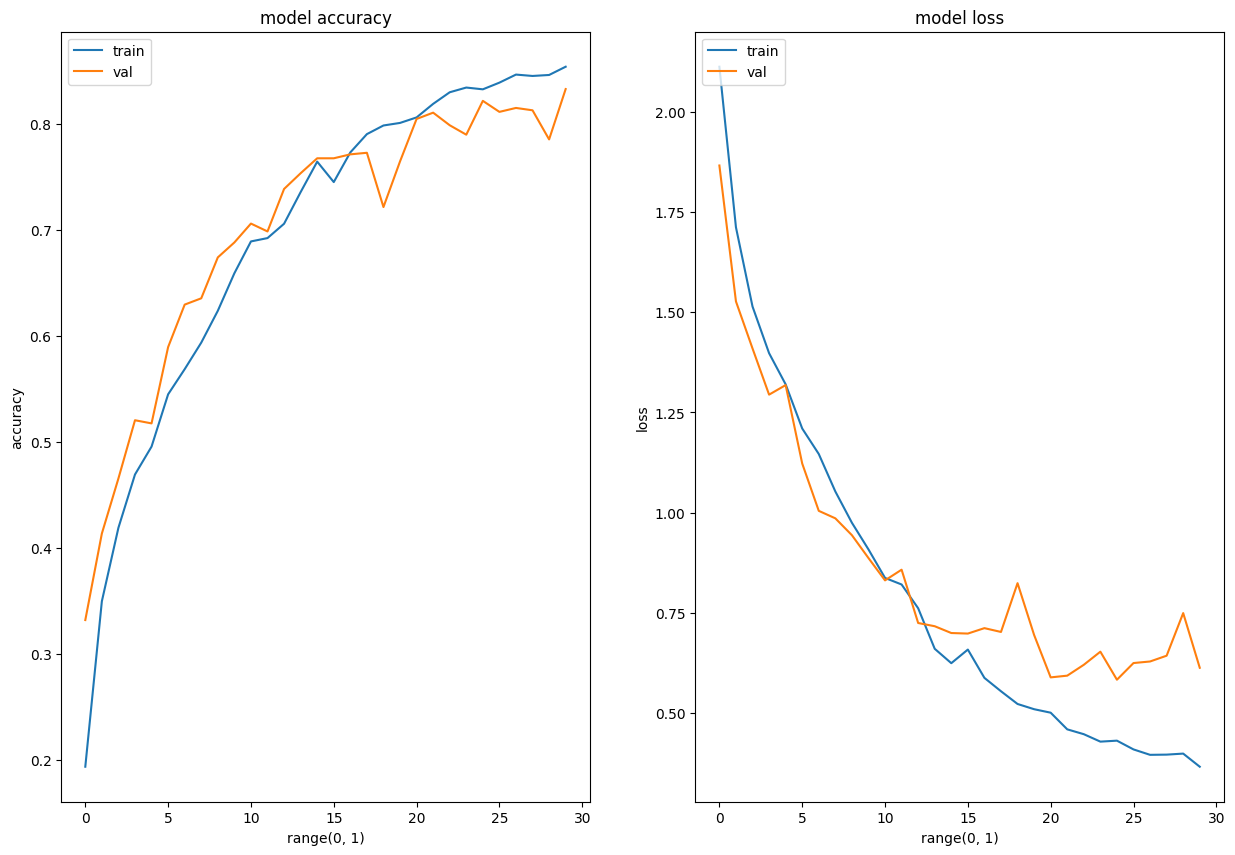

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As seen, with decrease in the regularization terms(dropout layer) of our model, it performs better on both the accuracy and validation accuracy metrics and becomes a better model. Further hyperparameter and layer tuning can also help further improve model performance if required. 

### Checking model prediction using random image from the test data set

1/1 [==============================] - 0s 187ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


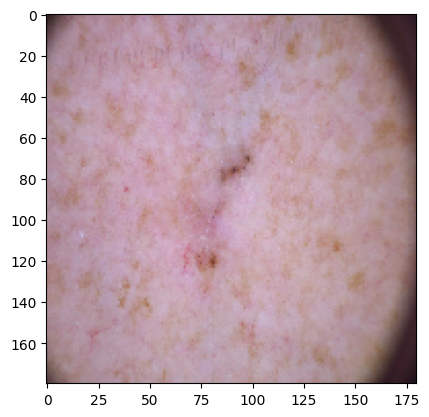

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model4.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

As visible above the model is able to acurately predict the type of skin cancer